# Redes Neuronales

In [21]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from collections import Counter
import requests

import keras
import tensorflow
from keras.datasets import mnist
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import optimizers

from sklearn.model_selection import KFold, StratifiedKFold

from preprocessing import *
plt.rcParams["figure.dpi"] = 60

# Carga del dataset
Leemos el dataset y lo separamos en datos de training y de evaluación.

In [2]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Entrenamiento y seleccion de modelos

Para encontrar el mejor modelo utilizaremos dos preprocesamientos distintos:
1) Aplica One Hot encoding en features categóricos y StandardScaler en features numéricos
2) Elimina features irrelevantes y aplica StandardScaler en features numéricos

## Modelo 1
Para el primer modelo, utilizaremos el preprocesamiento 2. Este dataset tiene 13 features, por lo tanto la cantidad de entradas de la red será 13 Entrenaremos una red simple, con una capa oculta de 13 neuronas con la función de activación tanh. Dado que realizaremos una clasificación binaria, la función de activación de la capa de salida es sigmoid. Como optimizador utilizaremos SGD, con un learning rate de 0.0005 (mediante prueba y error se llegó a este valor, aquí solo mostramos el entrenamiento definitivo).

In [4]:
X_train1 = preprocessing_redes_2(X_train)
X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X_train1, y_train, random_state=117, test_size=0.3, stratify=y_train)

model1 = Sequential()
model1.add(Dense(13, input_dim=13, activation='tanh'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=0.0005), metrics=[tensorflow.keras.metrics.AUC()])

In [5]:
history1 = model1.fit(X_train1.values, y_train1, epochs=300, verbose=2, validation_data=(X_validation1.values, y_validation1))


Epoch 1/300
1970/1970 - 3s - loss: 0.6241 - auc_1: 0.6651 - val_loss: 0.5613 - val_auc_1: 0.7278 - 3s/epoch - 2ms/step
Epoch 2/300
1970/1970 - 3s - loss: 0.5196 - auc_1: 0.7652 - val_loss: 0.4904 - val_auc_1: 0.7847 - 3s/epoch - 1ms/step
Epoch 3/300
1970/1970 - 3s - loss: 0.4671 - auc_1: 0.8020 - val_loss: 0.4512 - val_auc_1: 0.8098 - 3s/epoch - 1ms/step
Epoch 4/300
1970/1970 - 3s - loss: 0.4366 - auc_1: 0.8199 - val_loss: 0.4273 - val_auc_1: 0.8236 - 3s/epoch - 1ms/step
Epoch 5/300
1970/1970 - 3s - loss: 0.4174 - auc_1: 0.8306 - val_loss: 0.4115 - val_auc_1: 0.8322 - 3s/epoch - 1ms/step
Epoch 6/300
1970/1970 - 3s - loss: 0.4045 - auc_1: 0.8371 - val_loss: 0.4007 - val_auc_1: 0.8381 - 3s/epoch - 1ms/step
Epoch 7/300
1970/1970 - 3s - loss: 0.3956 - auc_1: 0.8418 - val_loss: 0.3930 - val_auc_1: 0.8423 - 3s/epoch - 2ms/step
Epoch 8/300
1970/1970 - 3s - loss: 0.3892 - auc_1: 0.8451 - val_loss: 0.3873 - val_auc_1: 0.8455 - 3s/epoch - 1ms/step
Epoch 9/300
1970/1970 - 3s - loss: 0.3844 - auc_

Después de 300 epochs se obtuvo un score **AUC = 0.8713** en el set de validación.

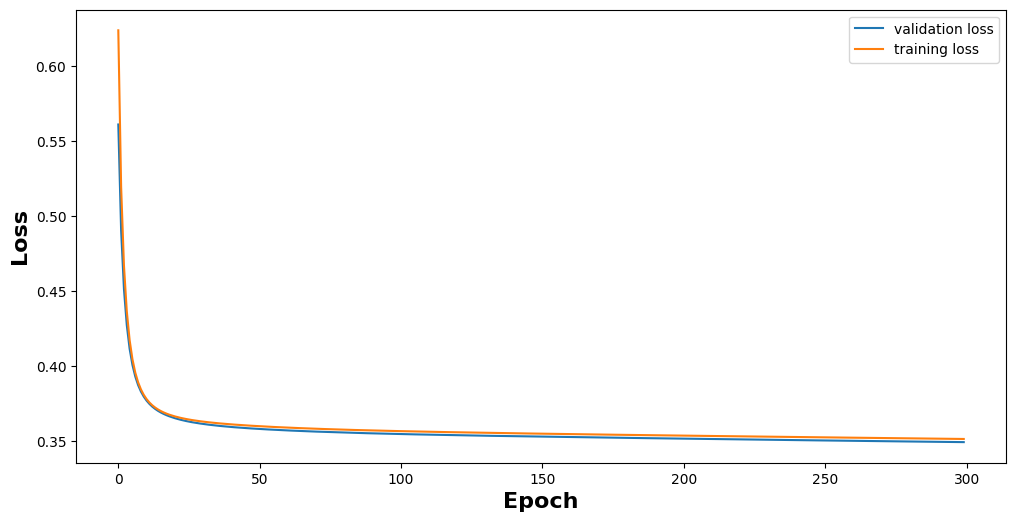

In [6]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(history1.history["val_loss"], label="validation loss")
plt.plot(history1.history["loss"], label="training loss")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("Loss", weight="bold", fontsize=16)
plt.legend()

En el gráfico podemos ver que el descenso del loss fue suave y lento, lo cual es esperable dado el bajo learning rate, y no se observa una diferencia notable entre el validation loss y el training loss, lo cual indica que no hay overfitting.

## Modelo 2
Ahora probamos con el dataset completo, que tiene 112 features que usaremos como input. La primera capa oculta tiene 112 neuronas, y la segunda es de 56 neuronas, ambas con función de activación ReLU. Utilizaremos regularizacion L1 en la capa oculta, y el optimizador Adam.

In [7]:
X_train2 = preprocessing_redes_1(X_train)
X_train2, X_validation2, y_train2, y_validation2 = train_test_split(X_train2, y_train, random_state=117, test_size=0.3, stratify=y_train)

model2 = Sequential()
model2.add(Dense(112, input_dim=112, activation='relu'))
model2.add(Dense(56, input_dim =112, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.l1(0.001)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[tensorflow.keras.metrics.AUC()])

In [8]:
history2 = model2.fit(X_train2.values, y_train2, epochs=100, verbose=2, validation_data=(X_validation2.values, y_validation2))


Epoch 1/100
1970/1970 - 4s - loss: 0.7406 - auc_2: 0.8371 - val_loss: 0.5514 - val_auc_2: 0.8662 - 4s/epoch - 2ms/step
Epoch 2/100
1970/1970 - 3s - loss: 0.4996 - auc_2: 0.8698 - val_loss: 0.4636 - val_auc_2: 0.8723 - 3s/epoch - 2ms/step
Epoch 3/100
1970/1970 - 3s - loss: 0.4440 - auc_2: 0.8735 - val_loss: 0.4276 - val_auc_2: 0.8739 - 3s/epoch - 2ms/step
Epoch 4/100
1970/1970 - 3s - loss: 0.4170 - auc_2: 0.8752 - val_loss: 0.4086 - val_auc_2: 0.8748 - 3s/epoch - 2ms/step
Epoch 5/100
1970/1970 - 3s - loss: 0.4011 - auc_2: 0.8760 - val_loss: 0.3944 - val_auc_2: 0.8764 - 3s/epoch - 2ms/step
Epoch 6/100
1970/1970 - 3s - loss: 0.3896 - auc_2: 0.8772 - val_loss: 0.3851 - val_auc_2: 0.8767 - 3s/epoch - 2ms/step
Epoch 7/100
1970/1970 - 3s - loss: 0.3814 - auc_2: 0.8780 - val_loss: 0.3784 - val_auc_2: 0.8777 - 3s/epoch - 2ms/step
Epoch 8/100
1970/1970 - 3s - loss: 0.3747 - auc_2: 0.8791 - val_loss: 0.3728 - val_auc_2: 0.8784 - 3s/epoch - 2ms/step
Epoch 9/100
1970/1970 - 3s - loss: 0.3702 - auc_

Después de 100 epochs se obtuvo un score **AUC = 0.8968** en el set de validación.

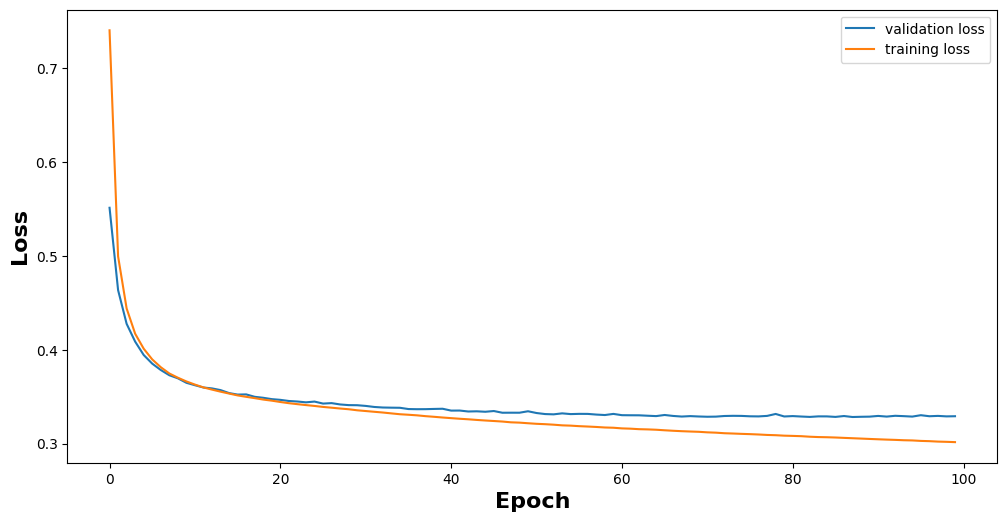

In [9]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(history2.history["val_loss"], label="validation loss")
plt.plot(history2.history["loss"], label="training loss")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("Loss", weight="bold", fontsize=16)
plt.legend()

En el gráfico podemos ver que, a diferencia del caso anterior, existe una mayor separación entre la curva del validation loss y la del training loss. El validation loss no disminuye a partir del epoch 50, mientras que el training loss sí lo hace, lo cual indica que tiende al overfitting.

## Modelo 3

Por último, probamos agregando regularizacion L1 en la primera capa, con el objetivo de evitar el overfitting que se vio en el modelo anterior. 

In [10]:
model3 = Sequential()
model3.add(Dense(112, input_dim=112, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.l1(0.001)))
model3.add(Dense(56, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.l1(0.001)))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[tensorflow.keras.metrics.AUC()])

In [11]:
history3 = model3.fit(X_train2.values, y_train2, epochs=100, verbose=2, validation_data=(X_validation2.values, y_validation2))


Epoch 1/100
1970/1970 - 4s - loss: 1.1846 - auc_3: 0.8315 - val_loss: 0.6663 - val_auc_3: 0.8606 - 4s/epoch - 2ms/step
Epoch 2/100
1970/1970 - 3s - loss: 0.5672 - auc_3: 0.8626 - val_loss: 0.5063 - val_auc_3: 0.8644 - 3s/epoch - 2ms/step
Epoch 3/100
1970/1970 - 3s - loss: 0.4807 - auc_3: 0.8639 - val_loss: 0.4589 - val_auc_3: 0.8658 - 3s/epoch - 2ms/step
Epoch 4/100
1970/1970 - 3s - loss: 0.4464 - auc_3: 0.8640 - val_loss: 0.4334 - val_auc_3: 0.8655 - 3s/epoch - 2ms/step
Epoch 5/100
1970/1970 - 3s - loss: 0.4274 - auc_3: 0.8642 - val_loss: 0.4204 - val_auc_3: 0.8660 - 3s/epoch - 2ms/step
Epoch 6/100
1970/1970 - 3s - loss: 0.4154 - auc_3: 0.8646 - val_loss: 0.4095 - val_auc_3: 0.8660 - 3s/epoch - 2ms/step
Epoch 7/100
1970/1970 - 3s - loss: 0.4071 - auc_3: 0.8648 - val_loss: 0.4019 - val_auc_3: 0.8662 - 3s/epoch - 2ms/step
Epoch 8/100
1970/1970 - 3s - loss: 0.4007 - auc_3: 0.8653 - val_loss: 0.3968 - val_auc_3: 0.8666 - 3s/epoch - 2ms/step
Epoch 9/100
1970/1970 - 3s - loss: 0.3963 - auc_

Después de 100 epochs se obtuvo un score **AUC = 0.8768** en el set de validación.

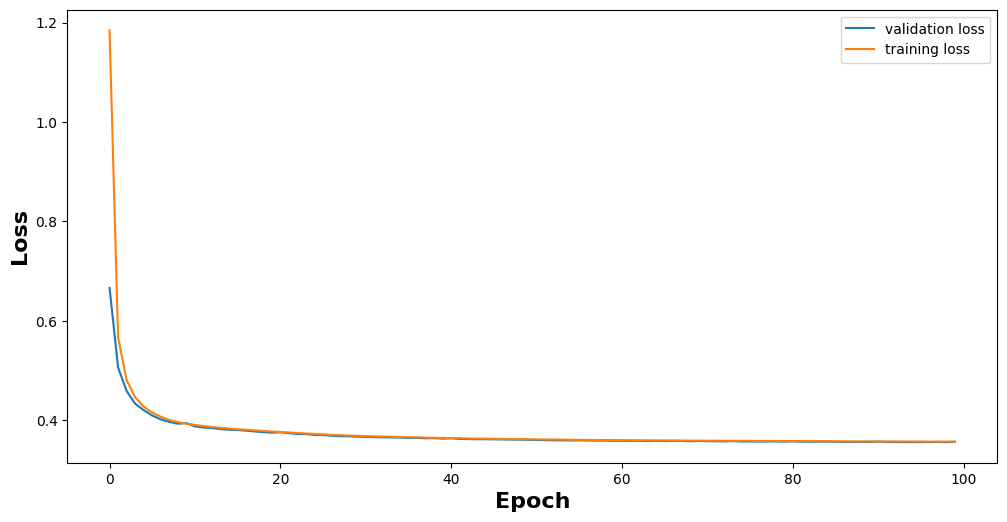

In [12]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(history3.history["val_loss"], label="validation loss")
plt.plot(history3.history["loss"], label="training loss")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("Loss", weight="bold", fontsize=16)
plt.legend()

Podemos observar que se logró evitar el overfitting, dado que las curvas de validation y training no se separan.

# Evaluacion del modelo final
A pesar de que vimos que el modelo 2 tiende al overfitting, obtuvo un score AUC en el set de validación mucho mayor que los otros modelos (0.8968). Por lo tanto, usaremos este como modelo definitivo, y evaluamos con los datos de evaluación.

In [13]:
X_eval = preprocessing_redes_1(X_eval)

y_pred = model2.predict(X_eval)

print(f"Auc Roc: {roc_auc_score(y_eval, y_pred)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred.round())}")
print(f"Precision: {precision_score(y_eval, y_pred.round())}")
print(f"Recall: {recall_score(y_eval, y_pred.round())}")
print(f"F1 Score: {f1_score(y_eval, y_pred.round())}")

Auc Roc: 0.8999452503200893
Accuracy: 0.8682921954631758
Precision: 0.7474972191323693
Recall: 0.6086956521739131
F1 Score: 0.6709935097353971


De las métricas podemos destacar que se obtuvo un accuracy de 0.87, mayor que el accuracy del baseline obtenido en el TP1 (0.83). Dado que el accuracy no es una buena métrica para evaluar un modelo cuando se usa un dataset desbalanceado como este, la métrica que usamos para comparar los modelos es AUC, la cual tiene un valor de 0.90.

También vemos que el recall obtenido (0.61) es mucho menor que el precision (0.75). Esto significa que, de todas las instancias que son realmente positivas (es decir, llueven hamburguesas al día siguiente), el modelo solo detecta correctamente el 61% de ellas. Por otro lado, de las que el modelo predice como positivas, el 75% eran realmente positivas.

Lo que más se destaca de estos resultados es que el modelo supera en todas las métricas (excepto Precisioin) a los otros modelos del TP. En la métrica Precision, solo es superado por KNN (Precision = 0.76). Teniendo en cuenta esto, consideramos que este es el mejor modelo.

Particularmente el recall (y por lo tanto el F1 Score) es mucho más alto que los que se obtuvieron en otros modelos.

    F1 = 2 x (precision x recall) / (precision + recall) = 0.67

Para analizar con más detalle estas métricas, graficaremos la matriz de confusión y la curva ROC.

## Matriz de confusión

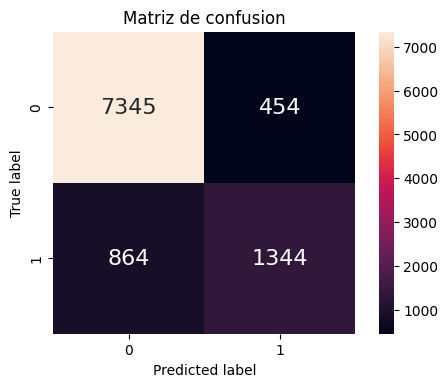

In [20]:
names = sorted(set(y_eval))
cm = confusion_matrix(y_eval, y_pred.round())
df_cm = pd.DataFrame(cm, names, names)

plt.figure(dpi=100)
plt.title("Matriz de confusion")
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

En la matriz de confusión podemos observar exactamente cuántas instancias fueron predichas como True Positive, True Negative, False Positive y False Negative. Se destaca cómo los valores de la diagonal principal (es decir, las instancias predichas correctamente) son muy superiores a los otros. A partir de estos datos se pueden calcular las métricas, verificando los resultados obtenidos anteriormente:
- Recall = TP/(TP+FN) = 1344/(1344+864) = 0.61
- Precision = TP/(TP+FP) = 1344/(1344+454) = 0.75
- Accuracy = (TP+TN)/total = 8689/10007 = 0.87

## Curva ROC

La curva ROC se obtiene al graficar el True Positive Rate (Recall) vs el False Positive Rate, variando el umbral de detección entre 0 y 100%. Si las predicciones hechas fueran completamente aleatorias, la curva sería una recta, con un área bajo la curva de 0.5. El área bajo la curva es la métrica que se obtiene de la curva, y por eso se busca obtener valores mayores que 0.5. En este caso se obtuvo un AUC = 0.90, el cual es el valor más alto obtenido en este TP.

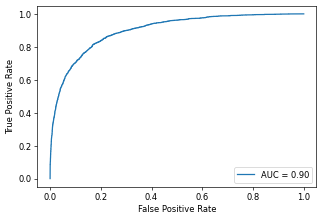

In [16]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Evaluación sobre holdout
Como este modelo es el que obtuvo el mejor AUC score (y las mejores métricas en general) en todo el TP, lo utilizaremos como modelo final, y lo probaremos con el dataset de holdout para obtener métricas más representativas de la realidad, ya que estos datos nunca fueron vistos por ningún modelo.

In [55]:
df_holdout = pd.read_csv("df_holdout.csv")
X_holdout = df_holdout.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y_holdout = df_holdout['llovieron_hamburguesas_al_dia_siguiente']
X_holdout = preprocessing_redes_1(X_holdout)
y_pred_holdout = model2.predict(X_holdout)

print(f"Auc Roc: {roc_auc_score(y_holdout, y_pred_holdout)}")
print(f"Accuracy: {accuracy_score(y_holdout, y_pred_holdout.round())}")
print(f"Precision: {precision_score(y_holdout, y_pred_holdout.round())}")
print(f"Recall: {recall_score(y_holdout, y_pred_holdout.round())}")
print(f"F1 Score: {f1_score(y_holdout, y_pred_holdout.round())}")

Auc Roc: 0.8981361306350503
Accuracy: 0.8615758229897463
Precision: 0.7334014300306435
Recall: 0.5854056257643702
F1 Score: 0.651099523917479


Podemos ver que las métricas obtenidas son peores que las que se obtuvieron anteriormente, lo cual suele suceder al utilizar un set de holdout ya que estos datos nunca fueron utilizados durante el entrenamiento (y no hubo ningún tipo de data leak).

# Predicciones finales

Finalmente, utilizaremos el modelo para predecir la lluvia de hamburguesas a partir de otro set de datos que no fueron usados en el entrenamiento. Guardaremos las predicciones en un archivo csv.

In [22]:
X_train2 = preprocessing_redes_1(X_train)

df_pred = pd.read_csv("pred.csv")

In [23]:
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_redes_1(df_pred_preprocess)
y_pred_final = np.rint(model2.predict(df_pred_preprocess)).astype('int').flatten()


In [27]:
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'


In [28]:
df_pred_final.to_csv('predicciones/redes_neuronales.csv', index=False)